In [52]:
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
features = pd.read_csv('features.csv', index_col='match_id')

Populating the interactive namespace from numpy and matplotlib


In [53]:
# Utils
import time
import datetime
from functools import wraps
from sklearn.metrics import roc_auc_score

def plot_barh(labels, values):
    n = len(values)
    f = plt.figure()
    ax = f.add_axes([0, 0, 1, 1])
    ax.barh(range(n), values, align='center')
    ax.set_yticks(range(n))
    ax.set_yticklabels(labels)
    f.show()

def plot_with_labels(x, y):
    plt.plot(x, y, '-o')
    for i in xrange(len(y)):
        plt.annotate("{0:.3f}".format(y[i]), (x[i], y[i]))
    plt.show()

def cross_validation(f):
    @wraps(f)
    def inner(X, y, kf, parameter):
        start_time = datetime.datetime.now()
        print("Parameter: {}".format(parameter))
        result = []
        for train_index, test_index in kf:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = f(parameter)
            clf.fit_transform(X_train, y_train)
            pred = clf.predict_proba(X_test)[:, 1]
            result.append(roc_auc_score(y_test, pred))
        print("Time elapsed: {}".format(datetime.datetime.now() - start_time))
        return np.mean(result)
    return inner

def auc_for_params(X, y, parameter_list, prediction_function):
    kf = KFold(X.shape[0], n_folds=5, shuffle=True)
    roc_aucs = []
    for parameter in parameter_list:
        roc_aucs.append(prediction_function(X, y, kf, parameter))
    plot_with_labels(parameter_list, roc_aucs)

## Градиентный бустинг

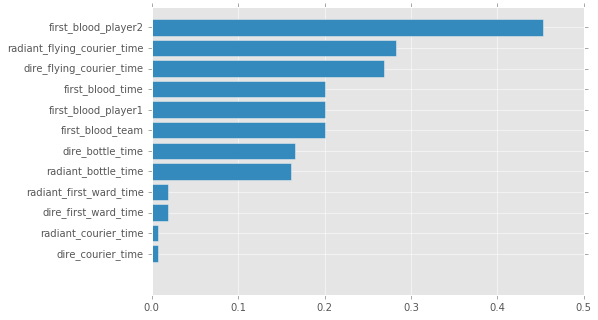

In [54]:
def missing_values_share(df):
    n = float(len(df.index))
    columns = [c for c in df.columns if df[c].count() != n]
    return {column: 1 - df[column].count()/n for column in columns}

missing_features = missing_values_share(features)
plot_barh(*zip(*sorted(missing_features.items(), key=lambda x: x[1])))

In [55]:
features.fillna(value=0, inplace=True)
features.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1, inplace=True)

Parameter: 5
Time elapsed: 0:00:23.231738
Parameter: 10
Time elapsed: 0:00:39.503617
Parameter: 15
Time elapsed: 0:00:56.340521
Parameter: 20
Time elapsed: 0:01:14.684952
Parameter: 25
Time elapsed: 0:01:35.329353
Parameter: 30
Time elapsed: 0:01:52.428229


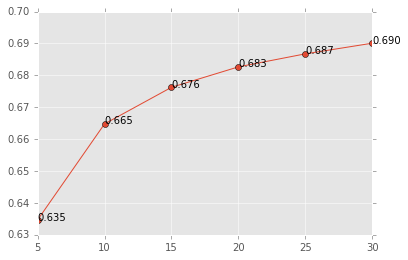

In [57]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold
import warnings
warnings.filterwarnings('ignore')

@cross_validation
def gradient_boosting(n_estimators=None):
    return GradientBoostingClassifier(n_estimators=n_estimators, verbose=False)

target = 'radiant_win'
auc_for_params(
    features[[c for c in features.columns if c != target]].values, 
    features[target].values,
    range(5, 31, 5),
    gradient_boosting
)

# Отчет

1) Какие признаки имеют пропуски среди своих значений (приведите полный список имен этих признаков)? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

Список признаков с пропусками значений: 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time'

* 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2' - за первые пять минут не произошло событие "первая кровь".
* 'radiant_bottle_time', 'dire_bottle_time' - соответствующая команда не приобрела предмет "bottle" в первые пять минут
* 'radiant_courier_time', 'dire_courier_time' - соответствующая команда не приобрела предмет "courier" в первые пять минут
* 'radiant_flying_courier_time', 'dire_flying_courier_time' - соответствующая команда не приобрела предмет "flying_courier" в первые пять минут 
* 'radiant_first_ward_time', 'dire_first_ward_time' - соответствующая команда не установила наблюдателя в первые пять минут

2) Как называется столбец, содержащий целевую переменную? - *radiant_win*

3) Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось?

Кросс-валидация проводилась около двух минут, качество 69%.

4) Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Судя по графику "количество деревьев - качество", максимум не был достигнут и следует продолжать увеличение количества деревьев. Однако чем больше деревьев, тем дольше обучается алгоритм. Несколько способов ускорить обучение на большом количестве деревьев:
* использовать не всю выборку, а её часть
* ограничить глубину дерева (в реализации GradientBoostingClassifier это может быть сделано с помощью аргументов max_depth или max_leaf_nodes)

# Логиcтическая регрессия

Parameter: -11.512925465
Time elapsed: 0:00:03.249477
Parameter: -9.21034037198
Time elapsed: 0:00:05.041777
Parameter: -6.90775527898
Time elapsed: 0:00:08.903448
Parameter: -4.60517018599
Time elapsed: 0:00:12.375742
Parameter: -2.30258509299
Time elapsed: 0:00:11.378819
Parameter: 0.0
Time elapsed: 0:00:12.173039
Parameter: 2.30258509299
Time elapsed: 0:00:10.669451
Parameter: 4.60517018599
Time elapsed: 0:00:10.605243


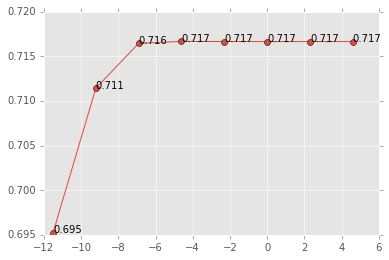

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

@cross_validation
def logistic_regression(C_exp):
    return LogisticRegression(penalty='l2', C=np.exp(C_exp))

X_log_df = features[[c for c in features.columns if c != target]]

target = 'radiant_win'
X_log = StandardScaler().fit_transform(X_log_df.values)
y_log = features[target].values
C_values = np.log([10**i for i in xrange(-5, 3)])  # use logarithmic scale for better plot

auc_for_params(
    X_log, 
    y_log,
    C_values,
    logistic_regression
)

In [116]:
def remove_categorical(df):
    heroes = ['r{}_hero'.format(i) for i in xrange(1, 6)] + ['d{}_hero'.format(i) for i in xrange(1, 6)]
    cat_variables = ['lobby_type'] + heroes
    return df.drop(cat_variables, axis=1)

X_log_no_cat_df = remove_categorical(X_log_df)
X_log_no_cat = StandardScaler().fit_transform(X_log_no_cat_df.values)

Parameter: -11.512925465
Time elapsed: 0:00:03.125241
Parameter: -9.21034037198
Time elapsed: 0:00:04.155110
Parameter: -6.90775527898
Time elapsed: 0:00:07.418202
Parameter: -4.60517018599
Time elapsed: 0:00:09.409904
Parameter: -2.30258509299
Time elapsed: 0:00:10.196769
Parameter: 0.0
Time elapsed: 0:00:10.306059
Parameter: 2.30258509299
Time elapsed: 0:00:10.017767
Parameter: 4.60517018599
Time elapsed: 0:00:09.971820


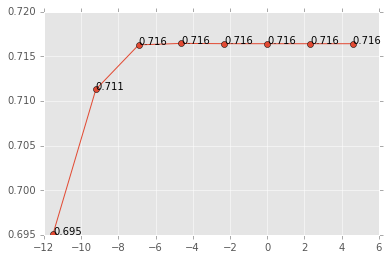

In [117]:
auc_for_params(
    X_log_no_cat, 
    y_log,
    C_values,
    logistic_regression
)

In [121]:
unique_heroes = np.unique(X_log_df[heroes].values)
n_heroes = len(unique_heroes)
unique_heroes_map = {h: i for i, h in enumerate(unique_heroes)}
print(n_heroes)

108


In [122]:
def add_heroes_information(df, no_cat_df):
    X_pick = np.zeros((df.shape[0], n_heroes))
    for i, match_id in enumerate(df.index):
        for p in xrange(5):
            X_pick[i, unique_heroes_map[df.ix[match_id, 'r{}_hero'.format(p+1)]]] = 1
            X_pick[i, unique_heroes_map[df.ix[match_id, 'd{}_hero'.format(p+1)]]] = -1
    X_log_cat_df = no_cat_df.copy()
    for i, h in enumerate(unique_heroes):
        X_log_cat_df[str(h)] = X_pick[:, i]
    return X_log_cat_df

In [114]:
X_log_cat_df = add_heroes_information(X_log_df, X_log_no_cat_df)

Parameter: -11.512925465
Time elapsed: 0:00:05.022472
Parameter: -9.21034037198
Time elapsed: 0:00:07.931039
Parameter: -6.90775527898
Time elapsed: 0:00:14.423736
Parameter: -4.60517018599
Time elapsed: 0:00:19.271460
Parameter: -2.30258509299
Time elapsed: 0:00:21.297459
Parameter: 0.0
Time elapsed: 0:00:21.183158
Parameter: 2.30258509299
Time elapsed: 0:00:21.027980
Parameter: 4.60517018599
Time elapsed: 0:00:26.155729


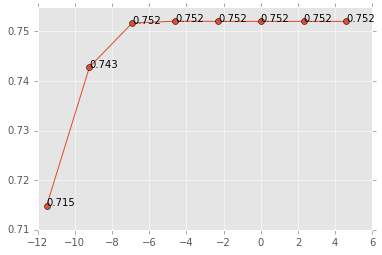

In [115]:
X_log_cat = StandardScaler().fit_transform(X_log_cat_df.values)

auc_for_params(
    X_log_cat, 
    y_log,
    C_values,
    logistic_regression
)

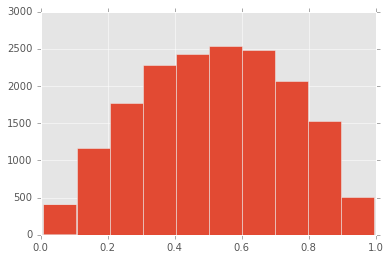

In [146]:
features_test = pd.read_csv('features_test.csv', index_col='match_id')
features_test.fillna(value=0, inplace=True)

def predict_logistic_regression(X_train, y_train, X_test):
    clf = LogisticRegression(penalty='l2', C=0.01)
    clf.fit_transform(X_train, y_train)
    return clf.predict_proba(X_test)[:, 1]

X_test_df = features_test[[c for c in features_test.columns if c != target]]
X_test_df = add_heroes_information(X_test_df, remove_categorical(X_test_df))
pred_log = predict_logistic_regression(X_log_cat, y_log, StandardScaler().fit_transform(X_test_df.values))
hist(pred_log)
plt.show()

In [147]:
with open('final_result.csv', 'w') as f:
    f.write('match_id,radiant_win\n')
    for m, r in zip(X_test_df.index, pred_log):
        f.write('{},{}\n'.format(m, r))

# Отчет

1) Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Значение метрики для логистической регресии примерно 0.71, что немного выше, чем метрика для градиентного бустинга - качество лучше. Логистическая регрессия работает значительно быстрее.

2) Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

Качество практически не изменилось, что показывает, что неправильно обработанные категориальные признаки не вносили значительного вклада в предсказание, будучи фактически шумом. 

3) Сколько различных идентификаторов героев существует в данной игре?

108

4) Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

При добавлении "мешка слов" качество улучшилось - метрика равна примерно 0.75. Это можно объяснить тем, что выбор героев играет важную роль в ходе игры, и их обязательно надо учитывать.

5) Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

Минимальное - 0.0087, максимальное - 0.996